# A Demonstration of LSTM for Predictive Maintenance

This tutorial is for beginners trying to learn how to build machine learning models for predictive maintenance  applications. This notebook shows how to build an LSTM model in Keras to predict if a machine is likely to fail within a time window (e.g. 50 cycles). Not to geek out too much, but this kind of problem is called "rare event time series forecasting". 

## Training Data

First, we need training data. It can be hard to fake training data that's condusive to modeling, so first I'll explain how I generated training data:

I created a multivariate time series dataset using an open source tool called, [logsynth](https://github.com/tdunning/log-synth). My dataset contains the following features:

* `cycle` - unit of time expressed in machine cycles
* `s1` - a sensor value measuring machine performance
* `s2` - another sensor value measuring machine performance

I configured logsynth so the training data simulates how a machine might go through periods of good performance, degraded performance, and outright failure. Here's how the sensor values change as the machine goes through good/degraded/failed states:

* ***Stage 1:*** Good performance. `s1` is random between (0,100). `s2` is a [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) with shape k=0.2.
* ***Stage 2:*** Degraded performance. `s1` is random between (500,750). `s2` is a gamma distribution with shape k=5.
* ***Stage 3:*** Failed performance. `s1` is random between (500,1000). `s2` continues with as gamma distribution with shape k=5.

The combined data for all three stages represents a single picture of a machine that goes from performing well, to degraded, to failure.  The idea here is that we get enough of these pictures then we will be able to train an ML model to predict that a machine is near failure when it's operating in what we have defined as the degraded state. The model produced good results by training it with 20 sequences of good/degraded/failed states. 

To generate this data, install logsynth to ~/development/ and run [PM3/generate_data.sh](https://raw.githubusercontent.com/mapr-demos/predictive-maintenance/master/notebooks/jupyter/PM3/generate_data.sh).


## Results

Scroll to the bottom to see how accurately it predicts failure for several test scenarios.

In [2]:
# Load keras libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping
model_path = './Output/LSTM_about_to_fail_model.h5'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

Using TensorFlow backend.


## Load training data

In [4]:
df_train=pd.read_json('PM3/PM_logsynth_train.json', lines=True)
print('Shape of Train dataset: ',df_train.shape)
df_train.head(5)

('Shape of Train dataset: ', (13538, 5))


,cycle,failure,max_life,s1,s2
0,0,0,577,97,1.176117
1,1,0,577,65,0.000723
2,2,0,577,4,0.921732
3,3,0,577,95,0.177239
4,4,0,577,20,3.626983


## Add labels for RUL and About_To_Fail 

Now we need to generate labels, like Remaining Useful Life (RUL) and About_To_Fail. These are the values that we're going to try to predict with an ML model.

In [5]:
# generate label columns for training data
df_train['rul']=df_train['max_life'] - df_train['cycle']
# We will make use of "about_to_fail" for binary classification, 
# while trying to answer the question: is a specific engine 
# going to fail within w1 cycles?
w1=50
about_to_fail_window=w1
df_train['about_to_fail'] = np.where(df_train['rul'] <= w1, 1, 0 )
df_train.head(df_train['max_life'][0]+3).tail(6)

,cycle,failure,max_life,s1,s2,rul,about_to_fail
574,574,0,577,558,0.782795,3,1
575,575,0,577,664,0.920564,2,1
576,576,0,577,744,1.157950,1,1
577,577,1,577,971,1.111066,0,1
578,578,1,577,912,0.727394,-1,1
579,579,1,577,740,1.056534,-2,1


In [7]:
df_test=pd.read_json('PM3/PM_logsynth_test1.json', lines=True)
df_test['rul']=df_test['max_life'] - df_test['cycle']
df_test['about_to_fail'] = df_test['rul'].apply(lambda x: 1 if x <= about_to_fail_window else 0)

In [8]:
features_cols=['cycle','s1','s2','about_to_fail']
# target_col_name='about_to_fail'

## Feature Scaling
Feature variables need to be normalized so they're within the similar ranges and scaled so they span values between 0 and 1. This is a common way to prepare data for machine learning.

In [ ]:
df_train.columns.difference(features_cols)

In [14]:
min_max_scaler=MinMaxScaler()
cols_normalize = df_train.columns.difference(features_cols)
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(df_train[cols_normalize]), 
                             columns=cols_normalize, 
                             index=df_train.index)
join_df = df_train[df_train.columns.difference(cols_normalize)].join(norm_train_df)
df_train = join_df.reindex(columns = df_train.columns)

cols_normalize = df_test.columns.difference(features_cols)
norm_test_df = pd.DataFrame(min_max_scaler.fit_transform(df_test[cols_normalize]), 
                             columns=cols_normalize, 
                             index=df_test.index)
join_df = df_test[df_test.columns.difference(cols_normalize)].join(norm_test_df)
df_test = join_df.reindex(columns = df_test.columns)

# df_train[features_col_name]=min_max_scaler.fit_transform(df_train[features_col_name])
# df_test[features_col_name]=min_max_scaler.transform(df_test[features_col_name])

/Users/idownard/development/customer360/jupyter/venv/lib/python2.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Put the training and test data into the shape required by LSTM
LSTM needs input data to be an array with dimensions `[samples, time steps, and features]`:

* Samples - these are all the rows in our time-series training data
* Time Steps - This is the look back window, or sequence length. LSTMs work better on windows with fewer than a couple hundred time steps ([see this reference](https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/)). We'll split the original time-series into sequences of length `seq_length`.
* Features columns - these are the feature variables that we want the LSTM to use for predicting events


In [15]:
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# function to generate labels
def gen_label(id_df, seq_length, seq_cols, label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [9]:
# Look back window is defined by seq_length. 
# split the training data into sub-sequences of length seq_length
seq_length=100
seq_cols=features_cols=['cycle','s1','s2']

Reformat training data and test data into the `[samples, time steps, features]` format explained above.

In [17]:
# generate X_train
X_train=np.array(list(gen_sequence(df_train, seq_length, seq_cols)))
print(X_train.shape)
# generate y_train
y_train=np.array(list(gen_label(df_train, seq_length, seq_cols, 'about_to_fail')))
print(y_train.shape)

(13537, 100, 3)
(13537,)


In [18]:
# generate X_test
X_test=np.array(list(gen_sequence(df_test, seq_length, seq_cols)))
print(X_test.shape)
# generate y_test
y_test=np.array(list(gen_label(df_test, seq_length, seq_cols, 'about_to_fail')))
print(y_test.shape)

(599, 100, 3)
(599,)


## Generate the LSTM model

Next, we build a deep network. The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. Dropout is also applied after each LSTM layer to control overfitting. Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.

I copied this LSTM implementation from here:
https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb

### LSTM Configuration

* We like LSTM because it has long-term memory, which we need for predicing rare time series events
* We add Dropout because it helps reduce overfitting by randomly dropping neurons. This helps improves accuracy and forces neurons to generalize better.
* We add Sigmoid function so the output of neurons is either 0 or 1. And we apply the Sigmoid with the Dense function so it gets applied to every neuron (i.e. as a fully connected layer).
* We must specify a loss function and an optimizer function when compiling the model. 
* The loss function is a way of penalizing the model for low accuracy scores. We use binary cross entropy because we have just two classes (1 and 0). 
* The optimizer defines how to adjust neuron weights in response to inaccuracate predictions. The Adam optimizer make sense, because I’ve read that Adam learns fast, is stable over a wide range of learning rates, and has comparatively low memory requirements. Keras uses a default learning rate of 0.001. 

References:
* https://github.com/keras-team/keras/issues/8461
* https://github.com/keras-team/keras/issues/7600

In [296]:
nb_features =X_train.shape[2]
timestamp=seq_length
label_gen = list(gen_label(df_test, seq_length, seq_cols, 'about_to_fail'))
label_array = np.array(label_gen).astype(np.float32)
label_array.shape
# nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(timestamp, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# fit the network
history = model.fit(X_train, y_train, epochs=5, batch_size=10, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100, 100)          41600     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 71,851
Trainable params: 71,851
Non-trainable params: 0
_________________________________________________________________
Train on 12860 samples, validate on 677 samples
Epoch 1/5
 - 218s - loss: 0.0542 - acc: 0.9842 - val_loss: 0.0259 - val_acc: 0.9911
Epoch 

## Sanity check model accuracy and loss
Accuracy should be great than 0.9, and loss should be less than 0.1.

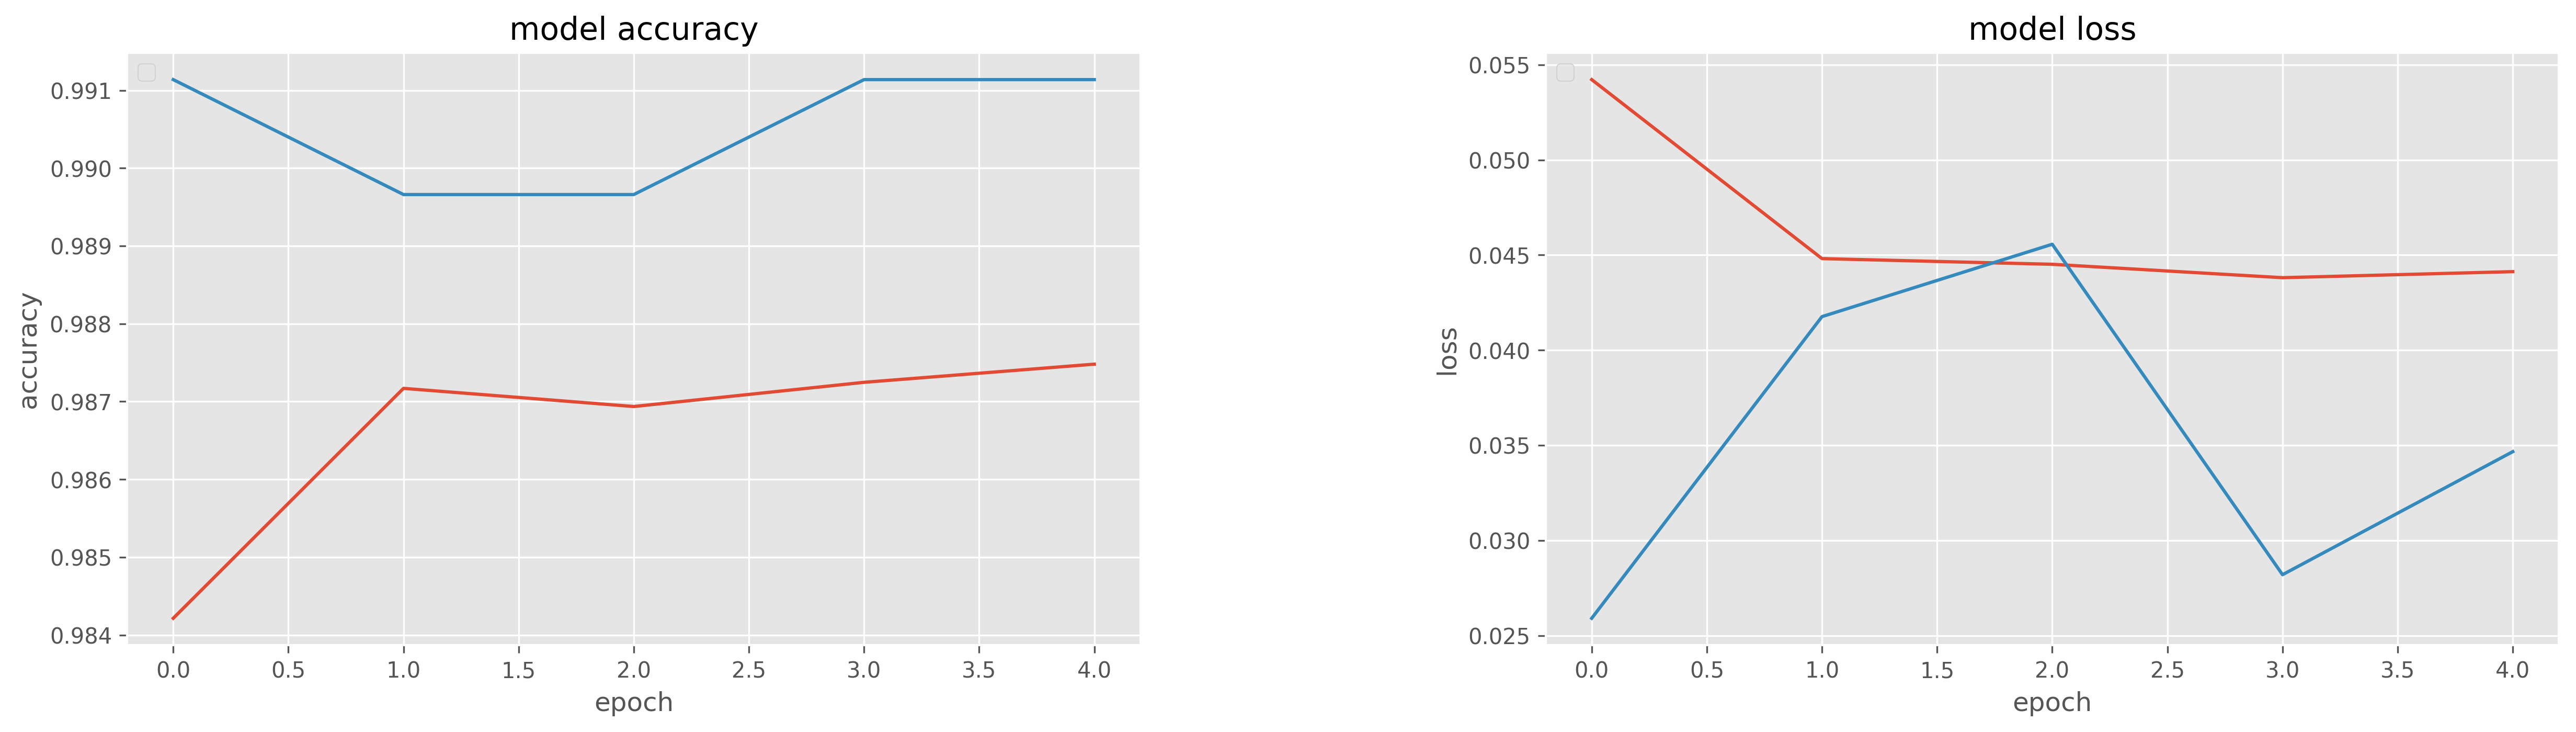

In [20]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(20, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.subplots_adjust(hspace=.4, wspace=.4)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.plot(saved_history['acc'])
plt.plot(saved_history['val_acc'])
# plt.show()
# fig_acc.savefig("./Output/model_accuracy.png")

# summarize history for Loss
plt.subplot(1, 2, 2)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.plot(saved_history['loss'])
plt.plot(saved_history['val_loss'])
# plt.show()
# fig_acc.savefig("./Output/model_loss.png")

# Save the model
These models take a long time to create. We'll save the model here so next time we want to run this notebook we don't have to recreate the model.

In [340]:
##################################
# Save model and training history
##################################

import pickle
filename = open("./Output/LSTM_about_to_fail_model_history","wb")
pickle.dump(history.history, filename)
filename.close()
        
# serialize model to JSON
model_json = model.to_json()
with open("./Output/LSTM_about_to_fail_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./Output/LSTM_about_to_fail_model.h5")
print("Saved model to disk")

Saved model to disk


# Load the model
If we just opened this notebook, you can load the previously saved model like this, so you don't have to recreate it.

In [26]:
###########################################
# Load model and training history from disk
###########################################
import pickle
history_file = open("./Output/LSTM_about_to_fail_model_history","rb")
history = pickle.load(history_file)
history_file.close()

# Load model from disk
from keras.models import model_from_json
# load json and create model
json_file = open("./Output/LSTM_about_to_fail_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("./Output/LSTM_about_to_fail_model.h5")
print("Loaded model from disk")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


In [27]:
# make predictions and compute confusion matrix
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
y_pred = model.predict_classes(X_train, verbose=1, batch_size=200)
y_true = y_train
# test_set = pd.DataFrame(y_pred)
#test_set.to_csv('./Output/binary_submit_train.csv', index = None)
print('Accuracy of predictions made on data used for training:\n{}'.format(scores[1]))
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ' + str(precision) + '\nrecall = ' + str(recall))

13537/13537 [==============================] - 10s 713us/step
Accuracy of predictions made on data used for training:
0.988254417726
precision = 0.9431602879878742
recall = 0.9963971176941553


## Compare predictions vs actual for training data. 
If these aren't nearly identical, then something must be really wrong because predictions will never be more accurate than when they're derived from the same data we used for training.

In [28]:
print('Confusion matrix on training data:\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
pd.DataFrame(cm).head(2)

Confusion matrix on training data:
- x-axis is true labels.
- y-axis is predicted labels


,0,1
0,10889,150
1,9,2489


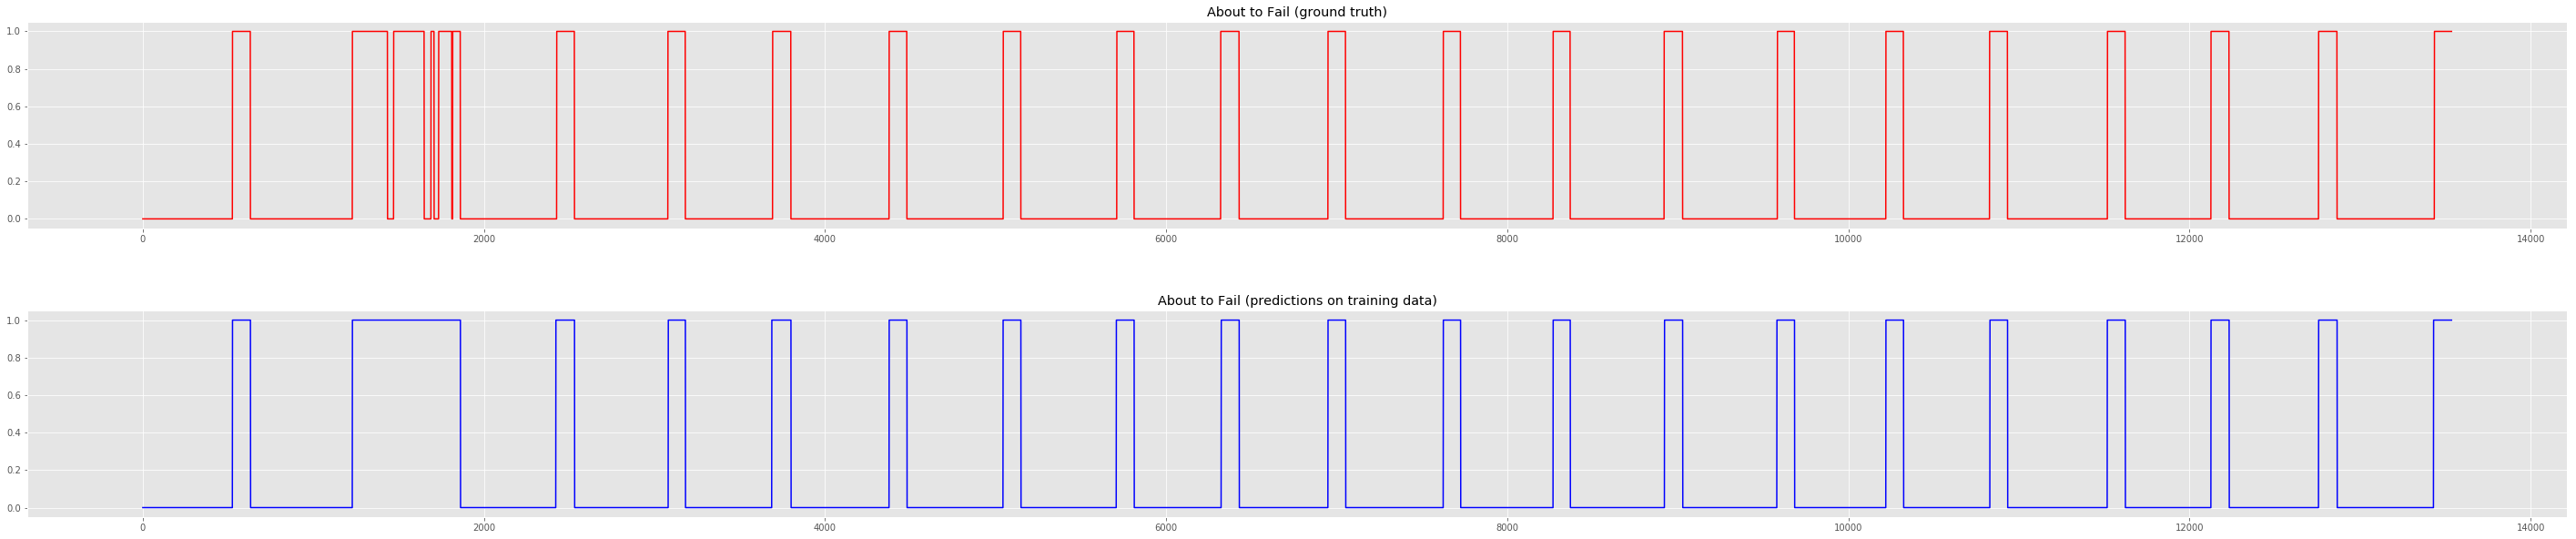

In [29]:
plt.figure(figsize=(50, 10))
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=.4, wspace=.4)
plt.title("About to Fail (ground truth)")
plt.plot(y_true,'r')
plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=.4, wspace=.4)
plt.title("About to Fail (predictions on training data)")
plt.plot(y_pred,'b')


In [30]:
y_pred2=model.predict_classes(X_test)
print('Accuracy of model on test data: ' + str(accuracy_score(y_test,y_pred2)))
print('Confusion matrix on training data:\n- x-axis is true labels.\n- y-axis is predicted labels')
pd.DataFrame(confusion_matrix(y_test,y_pred2)).head(2)

Accuracy of model on test data: 0.9115191986644408
Confusion matrix on training data:
- x-axis is true labels.
- y-axis is predicted labels


,0,1
0,499,0
1,53,47


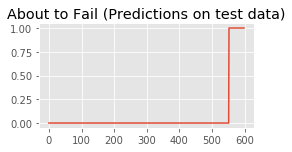

In [31]:
plt.figure(figsize=(20, 10))
plt.subplot(4, 4, 1)
plt.subplots_adjust(hspace=.4, wspace=.4)
plt.title("About to Fail (Predictions on test data)")
plt.plot(y_pred2)

## Functions for predicting failures

In [34]:
def prob_failure(df):
    test = gen_sequence(df,seq_length,seq_cols)
    m_pred = model.predict(test)
    failure_prob=list(m_pred[-1])[0]
    return failure_prob

def plot_prediction(df):
    X_test3=np.array(list(gen_sequence(df, seq_length, seq_cols)))
    y_test3=np.array(list(gen_label(df_test, seq_length, seq_cols, 'about_to_fail')))
    y_pred3=model.predict_classes(X_test3)
    confidence = model.predict(gen_sequence(df,seq_length,seq_cols))
    plt.figure(figsize=(20, 10), dpi=300)
    plt.subplot(4, 4, 1)
    plt.subplots_adjust(hspace=.4, wspace=.4)
    plt.title("About to Fail Within "+str(about_to_fail_window)+" cycles")
    plt.ylim(-.1, 1.1)
    plt.xlabel('cycles')
    plt.yticks(np.arange(2), ('False', 'True'))
    plt.plot(df['about_to_fail'], 'r', label='actual')
    plt.plot(y_pred3, 'b', label='predicted')
    plt.legend(loc='upper left')
    plt.subplot(4, 4, 2)
    plt.title("Probability of Failure")
    plt.ylim(-.1, 1.1)
    plt.xlabel('cycles')
    plt.plot(confidence,'r')
    print "Probability of failure within " + str(about_to_fail_window) + " cycles: {0:.1%}".format(prob_failure(df))
    print('Accuracy Score: {0:.2}'.format(accuracy_score(y_test3,y_pred3)))
    print('Confusion matrix:\n- x-axis is true labels.\n- y-axis is predicted labels')
    print(pd.DataFrame(confusion_matrix(y_test3,y_pred3)).head(2))

## Model Tests

Probability of failure within 50 cycles: 98.8%
Accuracy Score: 0.91
Confusion matrix:
- x-axis is true labels.
- y-axis is predicted labels
     0   1
0  499   0
1   53  47


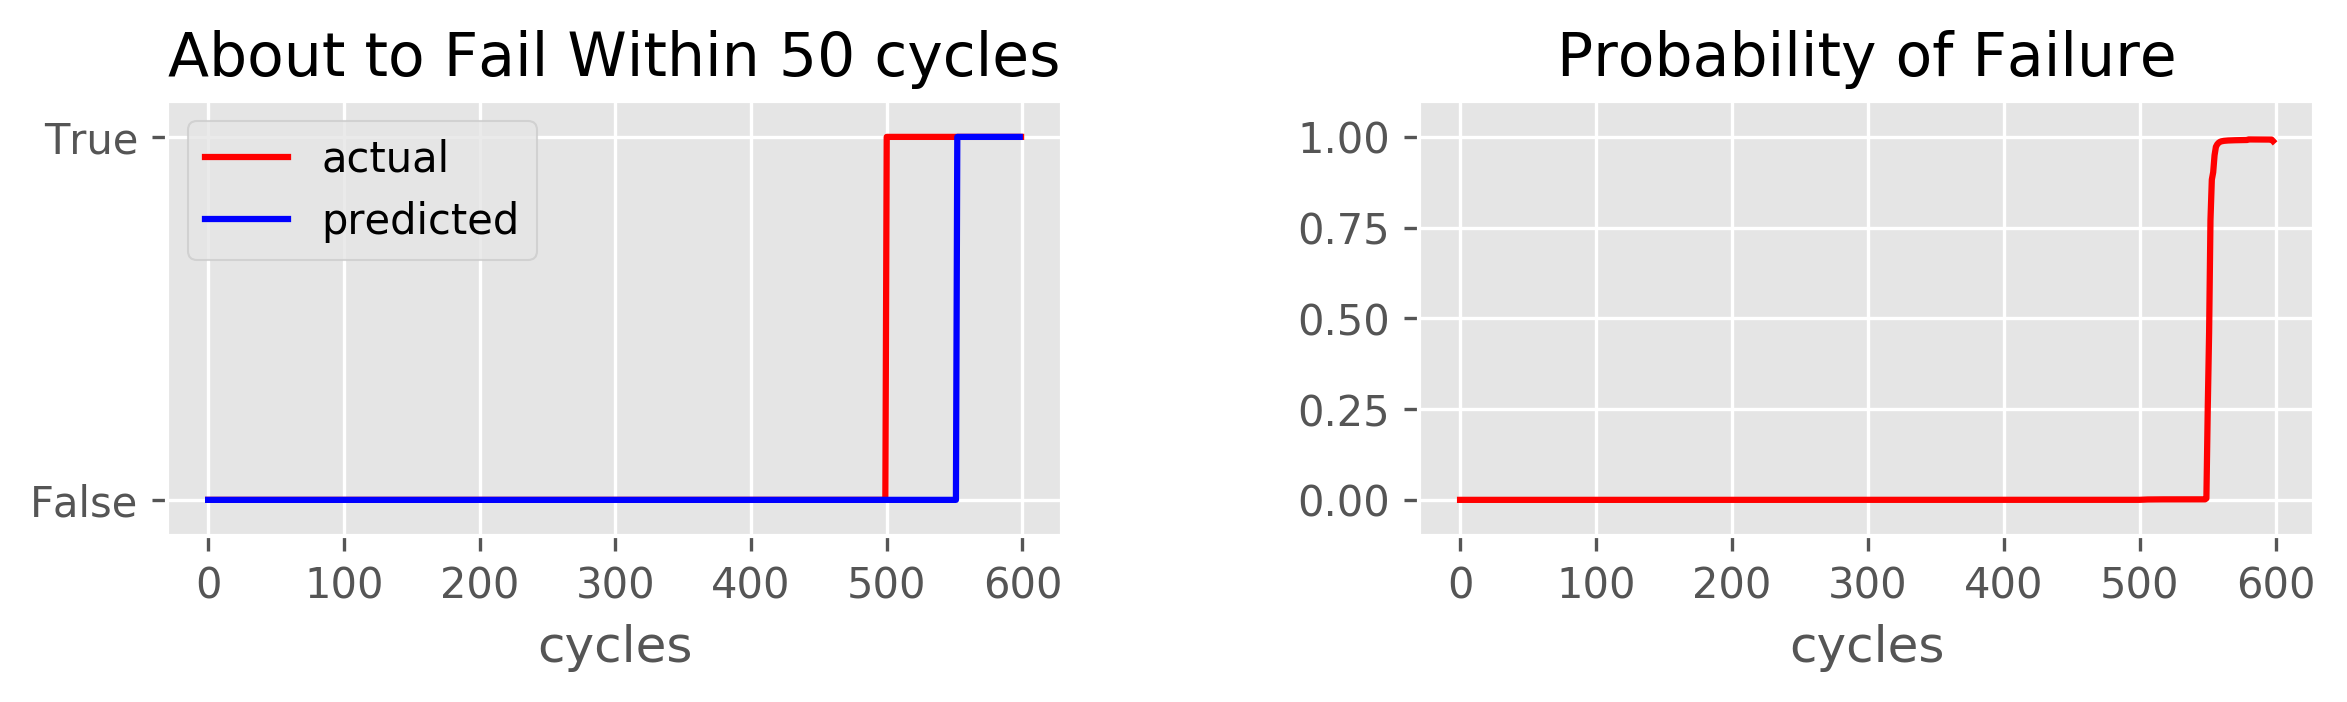

In [35]:
df=pd.read_json('Dataset/PM3/PM_logsynth_test1.json', lines=True)
df['rul']=df['max_life'] - df['cycle']
df['about_to_fail'] = np.where(df['rul'] <= w1, 1, 0 )
plot_prediction(df)

Probability of failure within 50 cycles: 0.0%
Accuracy Score: 0.83
Confusion matrix:
- x-axis is true labels.
- y-axis is predicted labels
     0  1
0  499  0
1  100  0


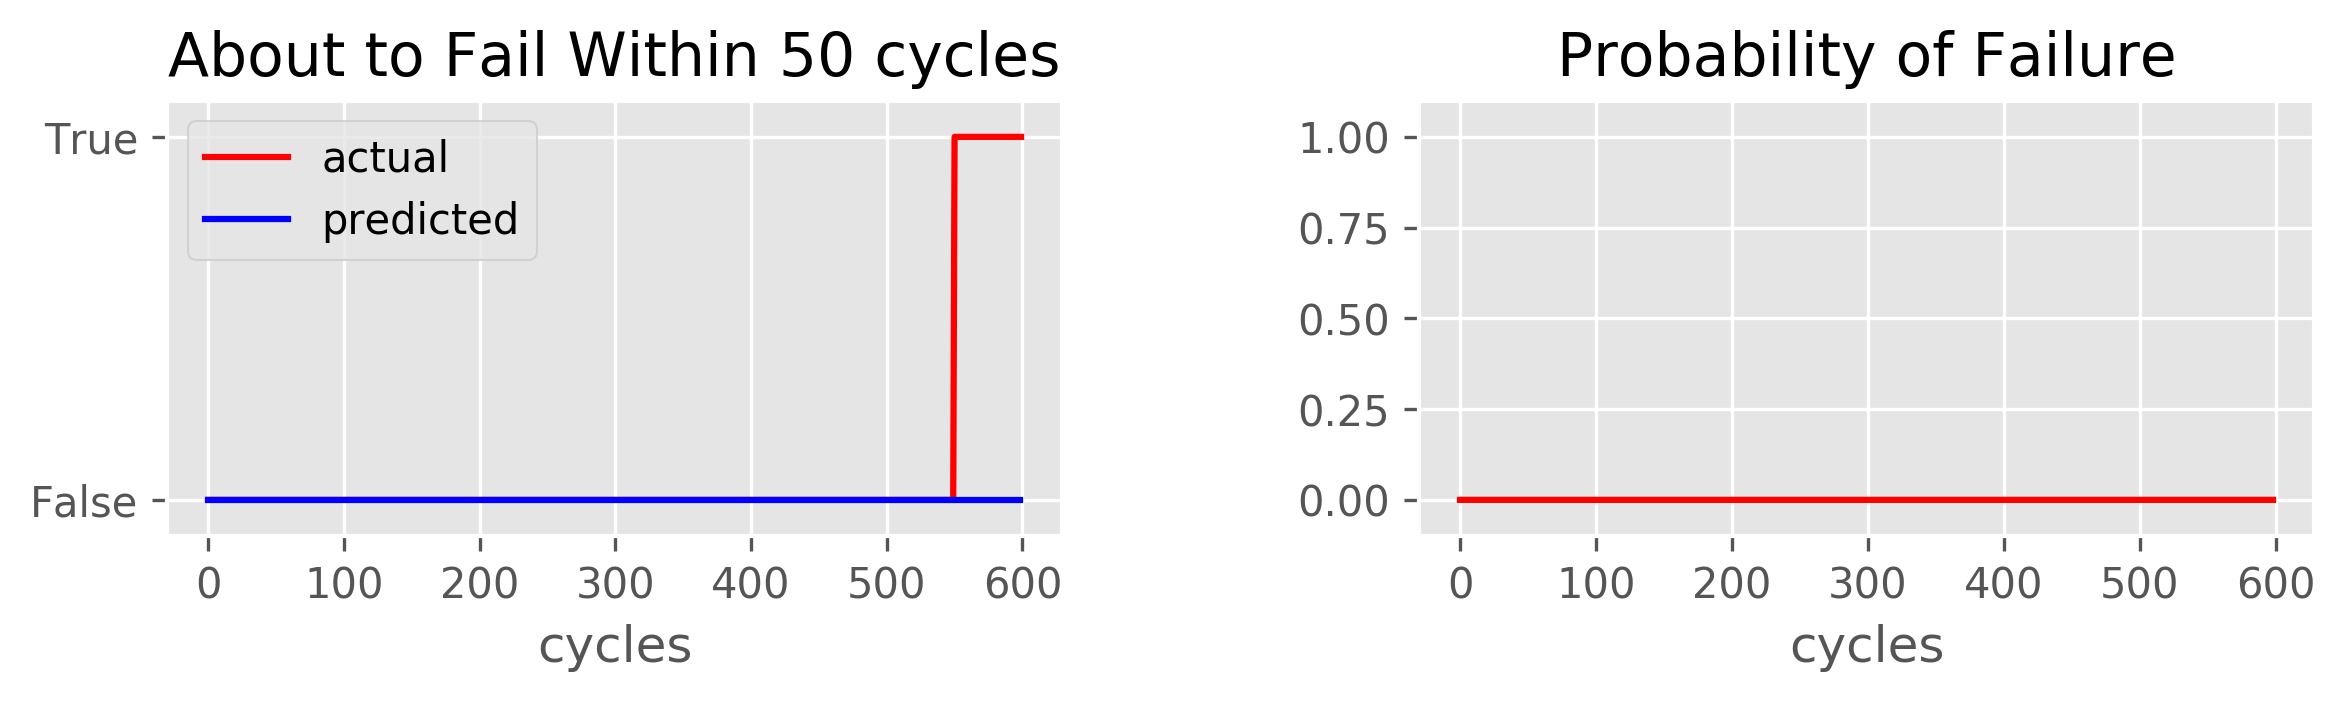

In [36]:
df=pd.read_json('Dataset/PM3/PM_logsynth_test2.json', lines=True)
df['rul']=df['max_life'] - df['cycle']
df['about_to_fail'] = np.where(df['rul'] <= w1, 1, 0 )
plot_prediction(df)

Probability of failure within 50 cycles: 89.1%
Accuracy Score: 0.59
Confusion matrix:
- x-axis is true labels.
- y-axis is predicted labels
     0    1
0  251  248
1    0  100


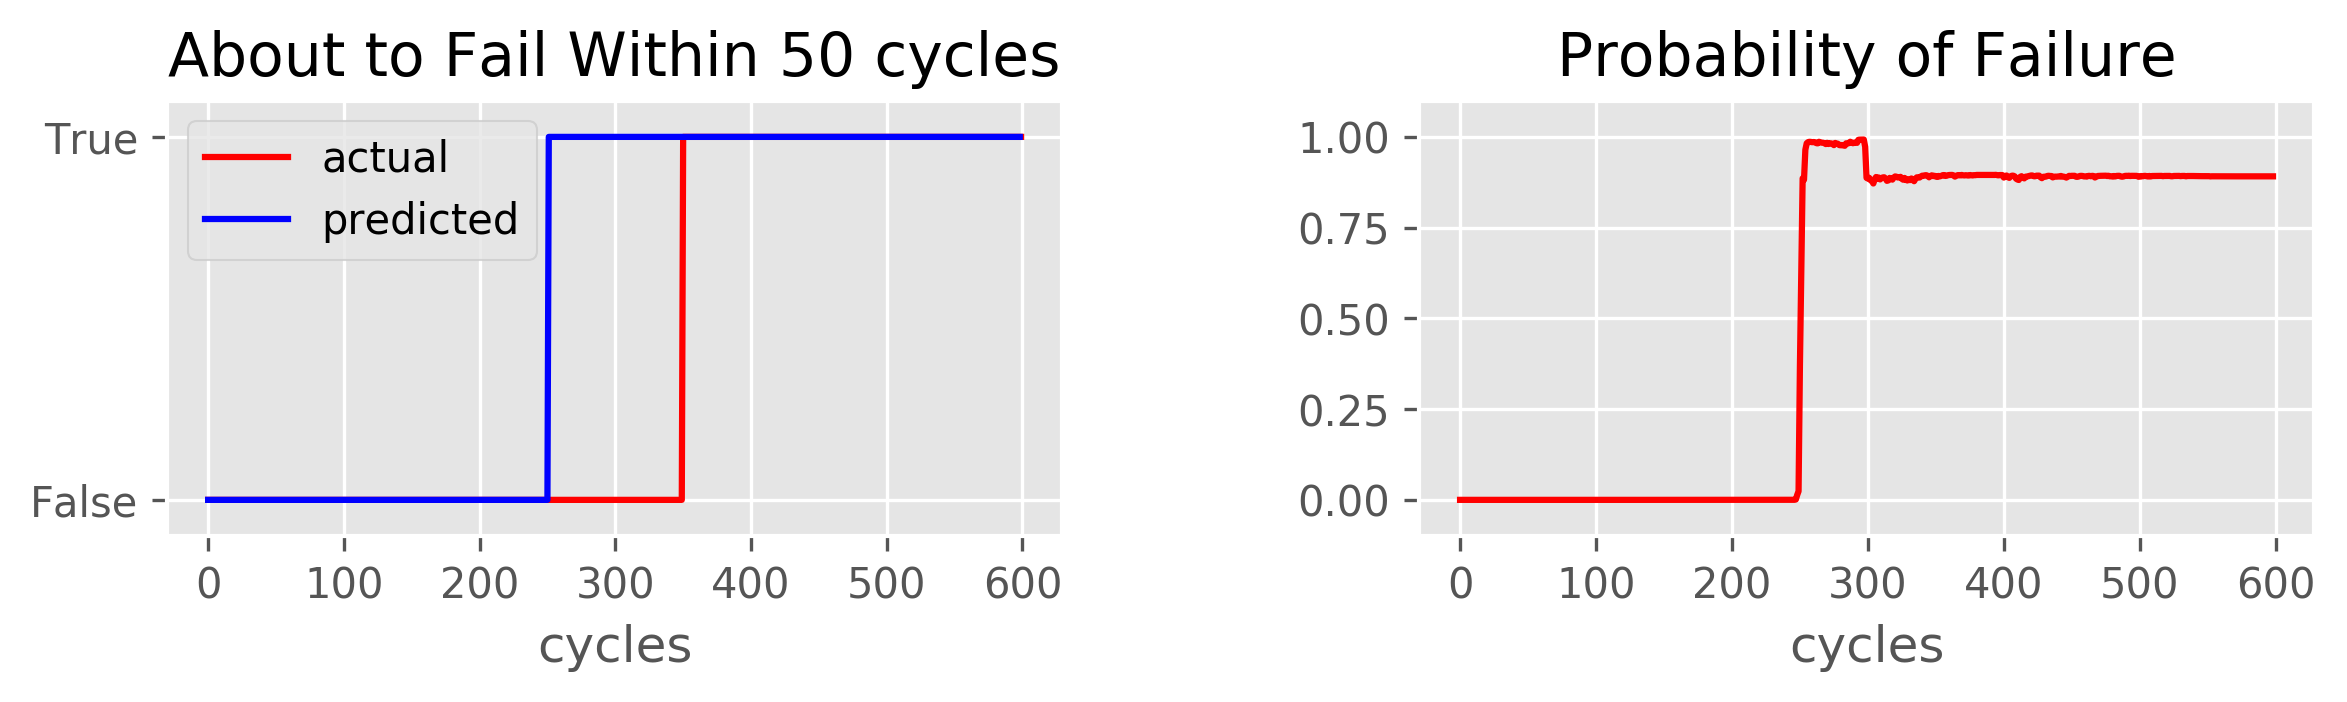

In [37]:
df=pd.read_json('Dataset/PM3/PM_logsynth_test3.json', lines=True)
df['rul']=df['max_life'] - df['cycle']
df['about_to_fail'] = np.where(df['rul'] <= w1, 1, 0 )
plot_prediction(df)

Probability of failure within 50 cycles: 89.1%
Accuracy Score: 0.57
Confusion matrix:
- x-axis is true labels.
- y-axis is predicted labels
     0    1
0  240  259
1    0  100


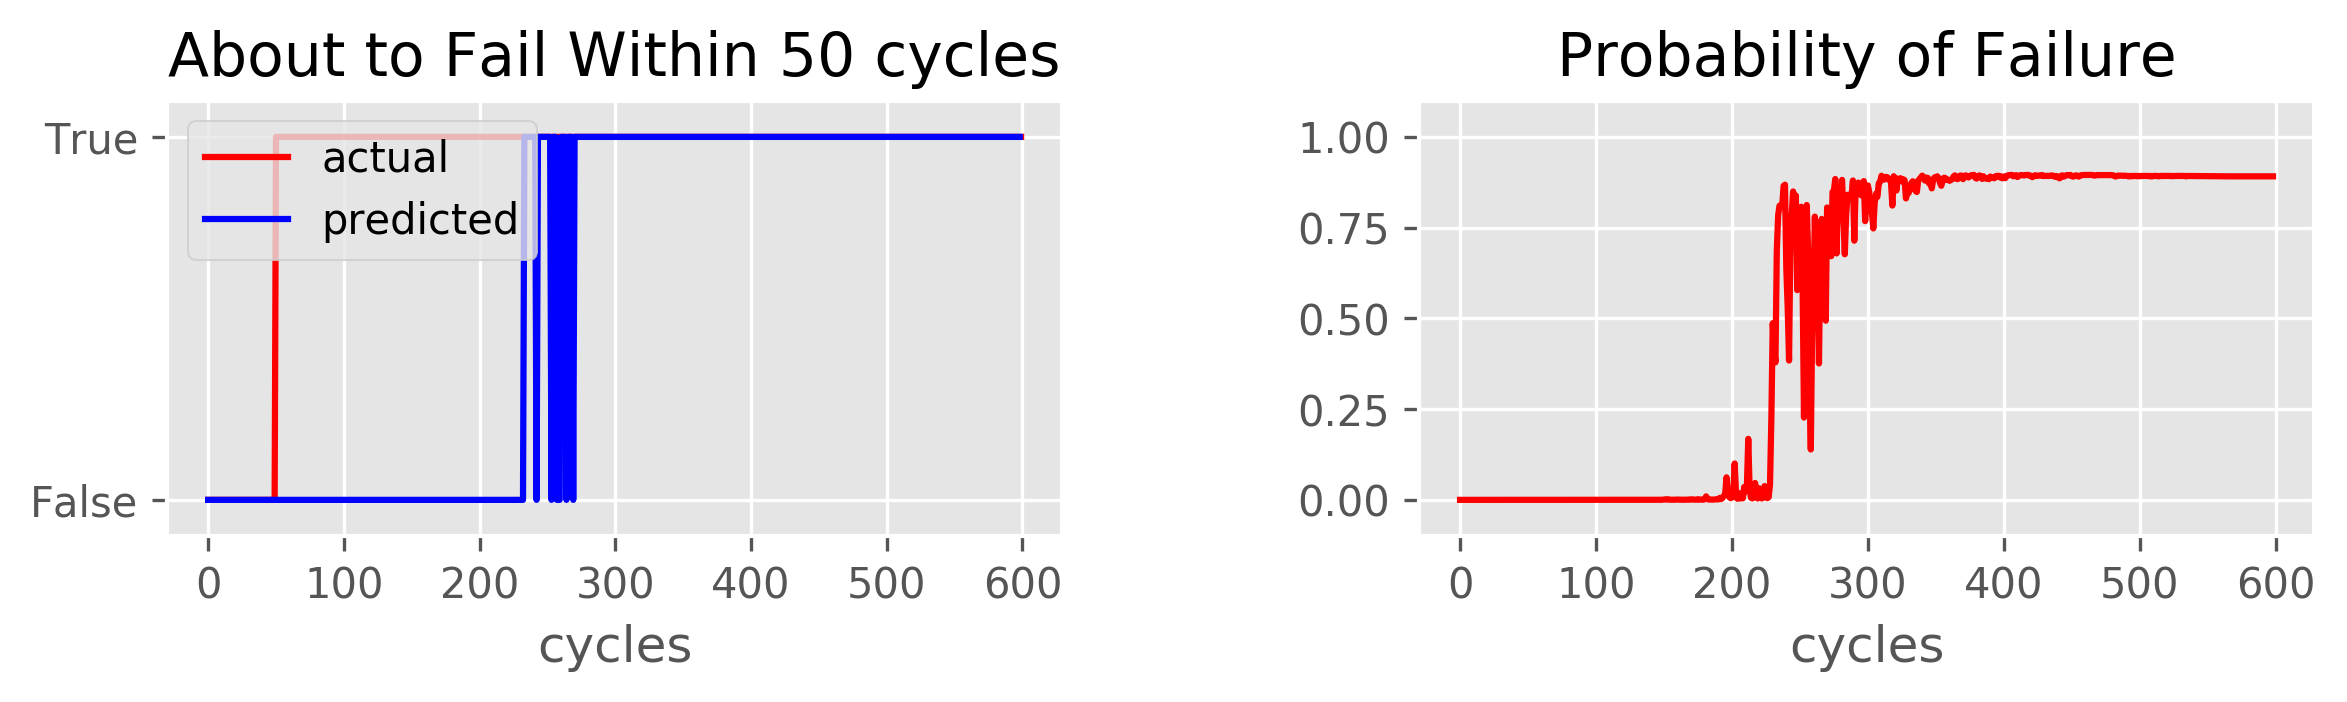

In [38]:
df=pd.read_json('Dataset/PM3/PM_logsynth_test4.json', lines=True)
df['rul']=df['max_life'] - df['cycle']
df['about_to_fail'] = np.where(df['rul'] <= w1, 1, 0 )
plot_prediction(df)

# References:

Here are some references that I've used to learn about LSTM and Predictive Maintenance model development.

1. Deep Learning for Predictive Maintenance https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb

2. Predictive Maintenance: Step 2A of 3, train and evaluate regression models https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2

3. A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan), NASA Ames Research Center, Moffett Field, CA

4. Understanding LSTM Networks http://colah.github.io/posts/2015-08-Understanding-LSTMs/
